In [142]:
import numpy as np
import pandas as pd
import csv
import os

from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering, DBSCAN

In [143]:
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize

from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image

def vectorize_images(images: np.ndarray) -> np.ndarray:
    """
    Vectorize images using CLIP from Hugging Face transformers.
    
    Args:
        images: List or array of images (batch_size, height, width, channels)
        
    Returns:
        numpy array of feature vectors (batch_size, feature_dim)
    """
    vectors = []
    batch_size = 16

    model_name = "openai/clip-vit-base-patch32"
    model = CLIPModel.from_pretrained(model_name)
    processor = CLIPProcessor.from_pretrained(model_name)

    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)

    # Convert numpy arrays to PIL Images
    pil_images = []
    for img_array in images:
        if len(img_array.shape) == 2:
            img_array = np.stack((img_array,) * 3, axis=-1)
        img = Image.fromarray((img_array * 255).astype('uint8')).convert('RGB')
        pil_images.append(img)

    # Process in batches
    for i in range(0, len(pil_images), batch_size):
        batch_images = pil_images[i:i + batch_size]
        inputs = processor(images=batch_images, return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            image_features = model.get_image_features(**inputs)
            image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
            vectors.append(image_features.cpu().numpy())

    return np.vstack(vectors)

from transformers import CLIPProcessor, CLIPModel
import torch
import numpy as np

def vectorize_text(texts: np.ndarray) -> np.ndarray:
    """
    Vectorize texts using CLIP from Hugging Face transformers.
    
    Args:
        texts: Array or list of text descriptions
        
    Returns:
        numpy array of feature vectors (batch_size, feature_dim)
    """
    vectors = []
    batch_size = 16

    model_name = "openai/clip-vit-base-patch32"
    model = CLIPModel.from_pretrained(model_name)
    processor = CLIPProcessor.from_pretrained(model_name)

    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)

    # Convert numpy array to list of strings if necessary
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()
    
    # Ensure all elements are strings
    texts = [str(text) for text in texts]

    # Process in batches
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = processor(text=batch_texts, return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            text_features = model.get_text_features(**inputs)
            text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)
            vectors.append(text_features.cpu().numpy())

    return np.vstack(vectors)

In [144]:
from sklearn.model_selection import train_test_split

def validation_split(X: np.ndarray, y: np.ndarray, test_size: float=0.2):
    """ Splits data into train and test."""
    return train_test_split(X, y, test_size=test_size, random_state=42)

In [145]:
def neighbour_search(
        text_req: np.ndarray,
        vImages: np.ndarray,
        top_k: int = 5
) -> np.ndarray:
    similarities = np.dot(text_req, vImages.T)
    return np.argsort(-similarities, axis=1)[:, :top_k]

In [146]:
import kaleido
import plotly.express as px

def visualize_embeddings(
    tsne_embeddings: np.ndarray, 
    pca_embeddings: np.ndarray, 
    labels: np.ndarray,
    file_name: str
):
    if tsne_embeddings.shape[1] == 2:
        tsne_df = pd.DataFrame(tsne_embeddings, columns=['tsne_x', 'tsne_y'])
        tsne_df['label'] = labels
        fig = px.scatter(tsne_df, x='tsne_x', y='tsne_y', color='label', title='t-SNE Embeddings (2D)')
        # fig.write_image("results/" + file_name + "-tsne2d.png")
        fig.show()

    if tsne_embeddings.shape[1] == 3:
        tsne_df = pd.DataFrame(tsne_embeddings, columns=['tsne_x', 'tsne_y', 'tsne_z'])
        tsne_df['label'] = labels
        fig = px.scatter_3d(tsne_df, x='tsne_x', y='tsne_y', z='tsne_z', color='label', title='t-SNE Embeddings (3D)')
        # fig.write_image("results/" + file_name + "-tsne3d.png")
        fig.show()

    if pca_embeddings.shape[1] == 2:
        pca_df = pd.DataFrame(pca_embeddings, columns=['pca_x', 'pca_y'])
        pca_df['label'] = labels
        fig = px.scatter(pca_df, x='pca_x', y='pca_y', color='label', title='PCA Embeddings (2D)')
        # fig.write_image("results/" + file_name + "-pca2d.png")
        fig.show()

    if pca_embeddings.shape[1] == 3:
        pca_df = pd.DataFrame(pca_embeddings, columns=['pca_x', 'pca_y', 'pca_z'])
        pca_df['label'] = labels
        fig = px.scatter_3d(pca_df, x='pca_x', y='pca_y', z='pca_z', color='label', title='PCA Embeddings (3D)')
        # fig.write_image("results/" + file_name + "-pca3d.png")
        fig.show()

In [147]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def visualize_clusters(
    vImages_viz_orig: np.ndarray,
    cluster_labels_orig: np.ndarray,
    vImages_pca: np.ndarray,
    cluster_labels_pca: np.ndarray,
    labels: np.ndarray,
    file_name: str
):
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
        subplot_titles=("", "")
    )

    scatter_orig = go.Scatter3d(
        x=vImages_viz_orig[:, 0],
        y=vImages_viz_orig[:, 1],
        z=vImages_viz_orig[:, 2],
        mode='markers',
        marker=dict(
            size=3,
            color=cluster_labels_orig.astype(float),
            colorscale='Viridis',
            opacity=0.8
        ),
        text=labels
    )
    fig.add_trace(scatter_orig, row=1, col=1)

    scatter_pca = go.Scatter3d(
        x=vImages_pca[:, 0],
        y=vImages_pca[:, 1],
        z=vImages_pca[:, 2],
        mode='markers',
        marker=dict(
            size=3,
            color=cluster_labels_pca.astype(float),
            colorscale='Viridis',
            opacity=0.8
        ),
        text=labels
    )
    fig.add_trace(scatter_pca, row=1, col=2)

    fig.update_layout(
        title="",
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        scene2=dict(
            xaxis_title='X ',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        margin=dict(l=0, r=0, b=0, t=50)
    )
    # fig.write_image("results/" + file_name + ".png")
    fig.show()

# The PCA class

In [148]:
class PCA:
    def __init__(self, n_components: int):
        """
        Initialize PCA with number of components to keep
        
        Args:
            n_components: Number of principal components to keep
        """
        self.n_components = n_components
        self.components = None
        self.mean = None
        self.std = None
        self.explained_variance_ = None
        self.explained_variance_ratio_ = None

    def standardize(self, X: np.ndarray) -> np.ndarray:
        """
        Normalize data by subtracting mean and dividing by std
        
        Args:
            X: Input data matrix of shape (n_samples, n_features)
            
        Returns:
            Normalized data matrix
        """
        if self.mean is None or self.std is None:
            self.mean = np.mean(X, axis=0)
            self.std = np.std(X, axis=0)
            
        X_norm = (X - self.mean) / self.std
        return X_norm

    def fit(self, X: np.ndarray) -> None:
        """
        Fit PCA model to data
        
        Args:
            X: Input data matrix of shape (n_samples, n_features)
        """
        # Standardize the data
        X_norm = self.standardize(X)
        
        # Calculate covariance matrix
        n_samples = X_norm.shape[0]
        covariance_matrix = np.dot(X_norm.T, X_norm) / (n_samples - 1)
        
        # Get eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
        
        # Sort eigenvalues and eigenvectors in descending order
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # Store components and explained variance
        self.components = eigenvectors[:, :self.n_components]
        self.explained_variance_ = eigenvalues[:self.n_components]
        self.explained_variance_ratio_ = (eigenvalues[:self.n_components] / 
                                        np.sum(eigenvalues))

    def transform(self, X: np.ndarray) -> np.ndarray:
        """
        Transform data using the principal components
        
        Args:
            X: Input data matrix of shape (n_samples, n_features)
            
        Returns:
            Transformed data matrix of shape (n_samples, n_components)
        """
        if self.components is None:
            raise ValueError("PCA model must be fitted before transform")
            
        # Standardize the data
        X_norm = self.standardize(X)
        
        # Project data onto principal components
        X_transformed = np.dot(X_norm, self.components)
        return X_transformed

    def inverse_transform(self, X: np.ndarray) -> np.ndarray:
        """
        Transform data back to original space
        
        Args:
            X: Transformed data matrix of shape (n_samples, n_components)
            
        Returns:
            Data matrix in original space of shape (n_samples, n_features)
        """
        if self.components is None:
            raise ValueError("PCA model must be fitted before inverse_transform")
            
        # Project back to original space
        X_original = np.dot(X, self.components.T)
        
        # Rescale the data
        X_original = (X_original * self.std) + self.mean
        return X_original

# the KMeans class

In [149]:
class KMeans:
    def __init__(self, n_clusters: int, max_iterations: int = 300, tol: float = 1e-4):
        """
        Initialize KMeans clustering algorithm
        
        Args:
            n_clusters: Number of clusters
            max_iterations: Maximum number of iterations for convergence
            tol: Tolerance for centroid movement to declare convergence
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iterations
        self.tol = tol
        self.centroids = None
        self.labels_ = None
        self.inertia_ = None
        self.n_iter_ = None

    def fit(self, X: np.ndarray) -> 'KMeans':
        """
        Fit KMeans clustering to the data
        
        Args:
            X: Input data of shape (n_samples, n_features)
            
        Returns:
            self: Fitted KMeans instance
        """
        n_samples, n_features = X.shape
        
        # Randomly initialize cluster centroids
        random_indices = np.random.permutation(n_samples)[:self.n_clusters]
        self.centroids = X[random_indices].copy()
        
        prev_centroids = None
        self.labels_ = np.zeros(n_samples)
        
        for iteration in range(self.max_iter):
            # Assign clusters
            self.labels_ = self.assign_clusters(self.centroids, X)
            
            # Update centroids
            new_centroids = self.compute_means(self.labels_, X)
            
            # Check for convergence
            if prev_centroids is not None:
                shifts = np.sqrt(((new_centroids - prev_centroids) ** 2).sum(axis=1))
                if np.all(shifts < self.tol):
                    self.n_iter_ = iteration + 1
                    break
            
            prev_centroids = new_centroids.copy()
            self.centroids = new_centroids
        
        # Set number of iterations if not converged
        if self.n_iter_ is None:
            self.n_iter_ = self.max_iter
            
        # Calculate inertia (sum of squared distances to closest centroid)
        self.inertia_ = self.compute_inertia(X)
        
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict cluster labels for new data
        
        Args:
            X: Input data of shape (n_samples, n_features)
            
        Returns:
            Array of cluster labels
        """
        if self.centroids is None:
            raise ValueError("Model must be fitted before making predictions")
            
        return self.assign_clusters(self.centroids, X)

    def fit_predict(self, X: np.ndarray) -> np.ndarray:
        """
        Fit and predict in one step
        
        Args:
            X: Input data of shape (n_samples, n_features)
            
        Returns:
            Array of cluster labels
        """
        return self.fit(X).labels_

    def assign_clusters(self, centroids: np.ndarray, X: np.ndarray) -> np.ndarray:
        """
        Assign clusters to samples based on nearest centroid
        
        Args:
            centroids: Array of centroids
            X: Input data
            
        Returns:
            Array of cluster assignments
        """
        distances = np.zeros((X.shape[0], self.n_clusters))
        
        # Calculate distances to each centroid
        for k in range(self.n_clusters):
            distances[:, k] = np.sqrt(((X - centroids[k]) ** 2).sum(axis=1))
            
        # Return index of closest centroid
        return np.argmin(distances, axis=1)

    def compute_means(self, clusters: np.ndarray, X: np.ndarray) -> np.ndarray:
        """
        Recompute cluster centroids by taking mean of assigned points
        
        Args:
            clusters: Array of cluster assignments
            X: Input data
            
        Returns:
            Array of new centroids
        """
        new_centroids = np.zeros((self.n_clusters, X.shape[1]))
        
        for k in range(self.n_clusters):
            mask = clusters == k
            if np.any(mask):  # Avoid empty clusters
                new_centroids[k] = X[mask].mean(axis=0)
            else:
                # If cluster is empty, keep old centroid
                new_centroids[k] = self.centroids[k]
                
        return new_centroids

    def compute_inertia(self, X: np.ndarray) -> float:
        """
        Calculate total inertia (within-cluster sum of squares)
        
        Args:
            X: Input data
            
        Returns:
            Total inertia value
        """
        inertia = 0
        for k in range(self.n_clusters):
            mask = self.labels_ == k
            if np.any(mask):
                cluster_points = X[mask]
                inertia += ((cluster_points - self.centroids[k]) ** 2).sum()
        return inertia

# load data

In [150]:
def convert_label_to_int(label: str) -> int:
    return 1 if label == 'human' else 0


def convert_int_to_label(value: int) -> str:
    return 'human' if value == 1 else 'animal'


def load_data(image_folder: str, label_file: str):
    """ Loads images and labels from the specified folder and file."""
    # load labels file
    labels = []
    image_names = []
    image_descriptions = []
    
    with open(label_file, 'r') as file:
        reader = csv.reader(file, delimiter="|")
        next(reader)
        for row in reader:
            image_names.append(row[0])
            image_descriptions.append(row[2])
            labels.append(convert_label_to_int(row[3]))

    # load corresponding images
    images = []

    for name in image_names:
        image = imread(os.path.join(image_folder, name))
        resized_image = resize(image, (224, 224))
        grayscale_image = rgb2gray(resized_image)
        images.append(grayscale_image)

    return np.array(images), np.array(labels), np.array(image_descriptions)

# load image data and text labels

In [151]:
input_path = 'dataset'

In [152]:
images, labels, descriptions = load_data(
    os.path.join(input_path, 'flickr30k_images'),
    os.path.join(input_path, 'labels.csv')
)

# vectorize images and text labels

In [153]:
vImages = vectorize_images(images)

In [154]:
pca_2d = PCA(n_components=2)
pca_2d.fit(vImages)
pca_2d_embeddings = pca_2d.transform(vImages)
pca_3d = PCA(n_components=3)
pca_3d.fit(vImages)
pca_3d_embeddings = pca_3d.transform(vImages)
print(f"PCA embeddings shapes: {pca_2d_embeddings.shape}, {pca_3d_embeddings.shape}")

PCA embeddings shapes: (300, 2), (300, 3)


In [155]:
tsne_2d = TSNE(n_components=2, random_state=42)
tsne_2d_embeddings = tsne_2d.fit_transform(vImages)
tsne_3d = TSNE(n_components=3, random_state=42)
tsne_3d_embeddings = tsne_3d.fit_transform(vImages)
print(f"t-SNE embeddings shapes: {tsne_2d_embeddings.shape}, {tsne_3d_embeddings.shape}")

t-SNE embeddings shapes: (300, 2), (300, 3)


# Visualize 2D and 3D embeddings of images and color points based on labels

In [156]:
visualize_embeddings(tsne_2d_embeddings, pca_2d_embeddings, labels, file_name="2d")
visualize_embeddings(tsne_3d_embeddings, pca_3d_embeddings, labels, file_name="3d")

In [157]:
n_clusters = 2

In [158]:
kmeans_org = KMeans(n_clusters=n_clusters, max_iterations=100)
kmeans_org.fit(vImages)
cluster_labels_org = kmeans_org.predict(vImages)

kmeans_pca = KMeans(n_clusters=n_clusters, max_iterations=100)
kmeans_pca.fit(pca_3d_embeddings)
cluster_labels_pca = kmeans_pca.predict(pca_3d_embeddings)

# Perform clustering on the embeddings and visualize the results

In [159]:
visualize_clusters(
    vImages[:, :3],
    cluster_labels_org,
    pca_3d_embeddings,
    cluster_labels_pca,
    labels,
    file_name="KMEANS"
)

In [160]:
from sklearn.metrics import silhouette_score

cluster_range = range(2, 10)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, max_iterations=100)
    kmeans.fit(pca_3d_embeddings)
    labels_k = kmeans.predict(pca_3d_embeddings)
    score = silhouette_score(pca_3d_embeddings, labels_k)
    print(f"Silhouette score for k={k}: {score}")

Silhouette score for k=2: 0.5009270310401917
Silhouette score for k=3: 0.4761947691440582
Silhouette score for k=4: 0.42083540558815
Silhouette score for k=5: 0.3736552298069
Silhouette score for k=6: 0.37840592861175537
Silhouette score for k=7: 0.2971041202545166
Silhouette score for k=8: 0.2994801700115204
Silhouette score for k=9: 0.2862951457500458


# Visualize 2D and 3D embeddings of images and color points based on cluster label and original labels

In [161]:
agglo = AgglomerativeClustering(n_clusters=n_clusters)
cluster_labels_hierarchical = agglo.fit_predict(pca_3d_embeddings)
visualize_clusters(
    pca_3d_embeddings,
    cluster_labels_pca,
    pca_3d_embeddings,
    cluster_labels_hierarchical,
    labels,
    file_name="AgglomerativeClustering"
)

# DBSCAN outlier detection

In [162]:
X_train, _, y_train, _ = validation_split(pca_3d_embeddings, labels)
clusterer = DBSCAN(eps=0.7, min_samples=3)
dbscan_labels = clusterer.fit_predict(X_train)
print(f"DBSCAN labels shape: {dbscan_labels.shape}")
visualize_clusters(
    X_train,
    kmeans_pca.predict(X_train),
    X_train,
    dbscan_labels,
    y_train,
    file_name="DBSCAN"
)

DBSCAN labels shape: (240,)


# Create a copy of your trained data with cleaned outliers 

In [163]:
non_outlier_indices = np.where(dbscan_labels != -1)[0]
X_train_clean = X_train[non_outlier_indices]

kmeans_clean = KMeans(n_clusters=n_clusters, max_iterations=100)
kmeans_clean.fit(X_train_clean)
kmeans_clean.predict(X_train_clean)
print(f"N of samples before: {X_train.shape[0]}, after: {X_train_clean.shape[0]}")

N of samples before: 240, after: 31


# Select few text descriptions and select nearest neighbors based on embeddings. 

In [164]:
vText = vectorize_text(descriptions)
top_k_indices = neighbour_search(vText, vImages, top_k=5)

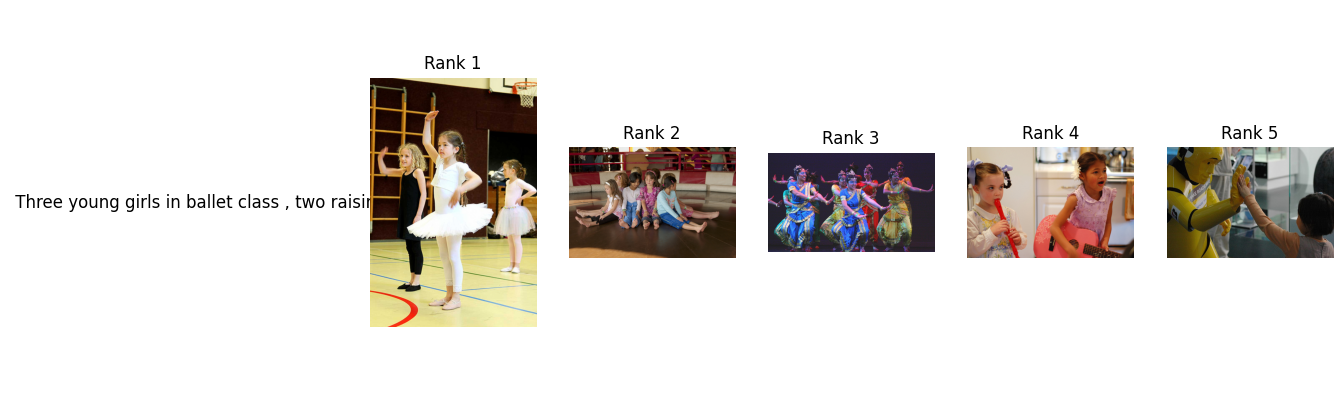

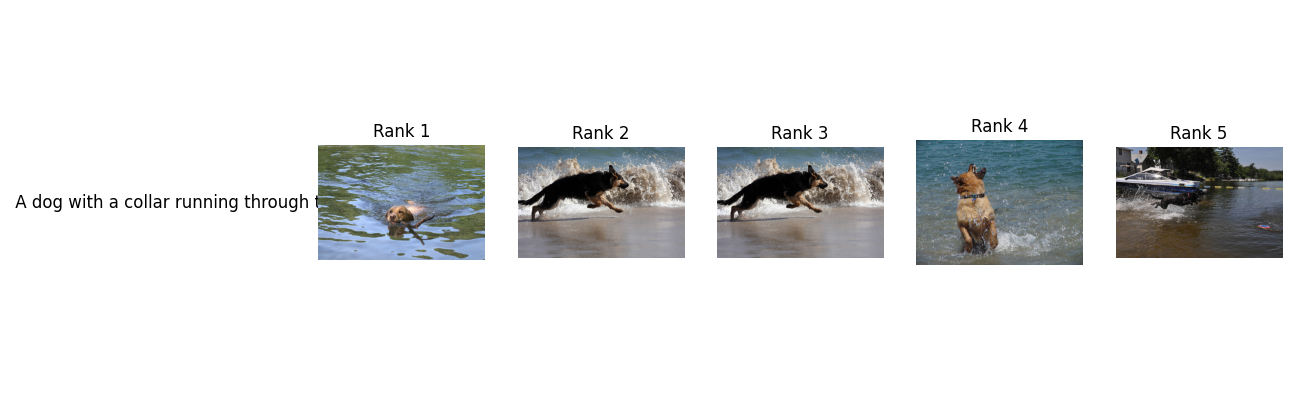

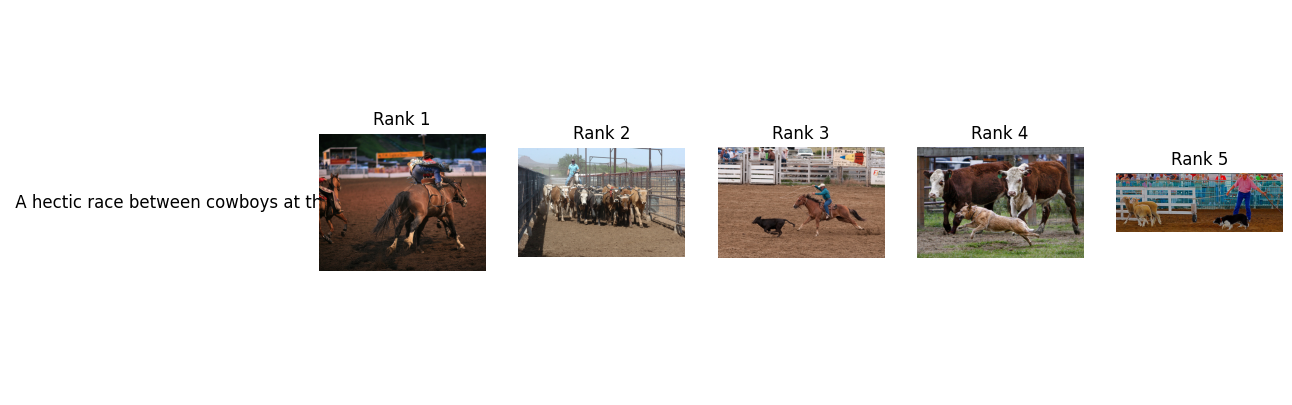

In [167]:
import random
from matplotlib import pyplot as plt

num_samples = 3

random_indices = random.sample(range(len(descriptions)), num_samples)
sampled_descriptions = [descriptions[i] for i in random_indices]
sampled_top_k_indices = [top_k_indices[i] for i in random_indices]

image_names = pd.read_csv(f"{input_path}/labels.csv", delimiter='|', skipinitialspace=True)['image_name'].tolist()

for i, text in enumerate(sampled_descriptions):
    indices = sampled_top_k_indices[i]
    _, axes = plt.subplots(1, len(indices) + 1, figsize=(15, 5))
    axes[0].text(0.5, 0.5, text, fontsize=12, ha='center', va='center')
    axes[0].axis('off')
    for j, idx in enumerate(indices):
        image_path = f"{input_path}/flickr30k_images/{image_names[idx]}"
        img = Image.open(image_path)
        axes[j + 1].imshow(img)
        axes[j + 1].axis('off')
        axes[j + 1].set_title(f"Rank {j + 1}")
    
    # plt.savefig("results/text" + text + ".png")
    plt.show()
    plt.close()